In [1]:
%matplotlib inline

# Importing necessary libraries and modules
import numpy as np # for numerical computing
import pandas as pd # for manipulation and analysis
import os # for interacting with the operating system 
import matplotlib.pyplot as plt # for creating visualizations
from PIL import Image # for working with images

import torch # for machine learning
import torch.nn as nn # for building neural networks in PyTorch
import torch.optim as optim # for optimizing neural networks in PyTorch
import torchvision # for computer vision tasks in PyTorch
from torchvision import models, transforms # for loading and preprocessing image data
import torchvision.models as models # for using pre-trained models in PyTorch
from torch.utils.data import DataLoader, Dataset # for working with datasets in PyTorch

In [2]:
!pip install torchview -q

In [5]:
import torchview


In [12]:
base_dir = '../input/'
train_csv = 'train.csv'
test_csv = 'test.csv'


# Set the device which we will be using for the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Defining a custom dataset class for loading and preprocessing image data
class manualDataset(Dataset):
    def __init__(self, file_path, split='train', val_split=False):
        df = pd.read_csv(file_path)
        self.split = split
        self.val_split = val_split
        if self.split=='test' and val_split==False :
            # test data
            self.raw_files = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.labels = None
        else:
            # training data
            self.raw_files = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.labels = torch.from_numpy(df.iloc[:,0].values)
        
        if(val_split):
            self.raw_files = self.raw_files[:10]
          
       
        # Defining the transformations to be applied to the images
        self.train_transform = transforms.Compose([ transforms.ToPILImage(),transforms.RandomHorizontalFlip(), transforms.ToTensor()])
        self.test_transform = transforms.Compose([ transforms.ToTensor()])
          

        
    def __len__(self):
        return len(self.raw_files)
    
    def __getitem__(self, idx):
        # Reading in the image file
        raw = self.raw_files[idx]
      
        
        # Applying the appropriate transformation based on the split
        if self.split == 'train' or self.val_split:
            raw = self.train_transform(raw)
            label = self.labels[idx]
            return raw, label
        elif self.split == 'test':
            raw = self.test_transform(raw)
            return raw
        
        
        
        

In [13]:
# Creating instances of the manualDataset class for the training, testing, and validation datasets
train_dataset = manualDataset(train_csv, split='train')
test_dataset = manualDataset(test_csv, split='test')
val_dataset = manualDataset(train_csv, split='test', val_split=True)

# Defining the batch sizes for the training and testing data
train_batch_size = 32
test_batch_size = 1

# Creating instances of the DataLoader class for the training, testing, and validation data
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

Creating a Convolutional Network


In [14]:
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Convolutional layer with 32 output channels
            nn.BatchNorm2d(32),  # Batch normalization to normalize the outputs
            nn.ReLU(inplace=True),  # ReLU activation function for introducing non-linearity
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # Another convolutional layer with 32 output channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer to reduce the spatial dimensions
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer with 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Another convolutional layer with 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer to reduce the spatial dimensions
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout layer to prevent overfitting
            nn.Linear(64 * 7 * 7, 512),  # Fully connected layer with 512 output units
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),  # Another fully connected layer with 512 output units
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)  # Final fully connected layer with 10 output units (corresponding to classes)
        )
        
    def forward(self, x):
        x = self.cnn(x)  # Pass the input through the CNN layers
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass the flattened output through the fully connected layers
        
        return x

Visualizing Our Model & Training Dataset
We first visualize the CNN model that we have defined above

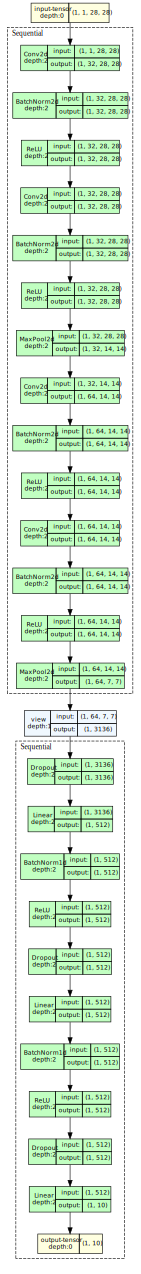

In [17]:
from torchview import draw_graph
model_graph = draw_graph(CNN(), input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph

In [18]:
import seaborn as sns # use seaborn for better visualization

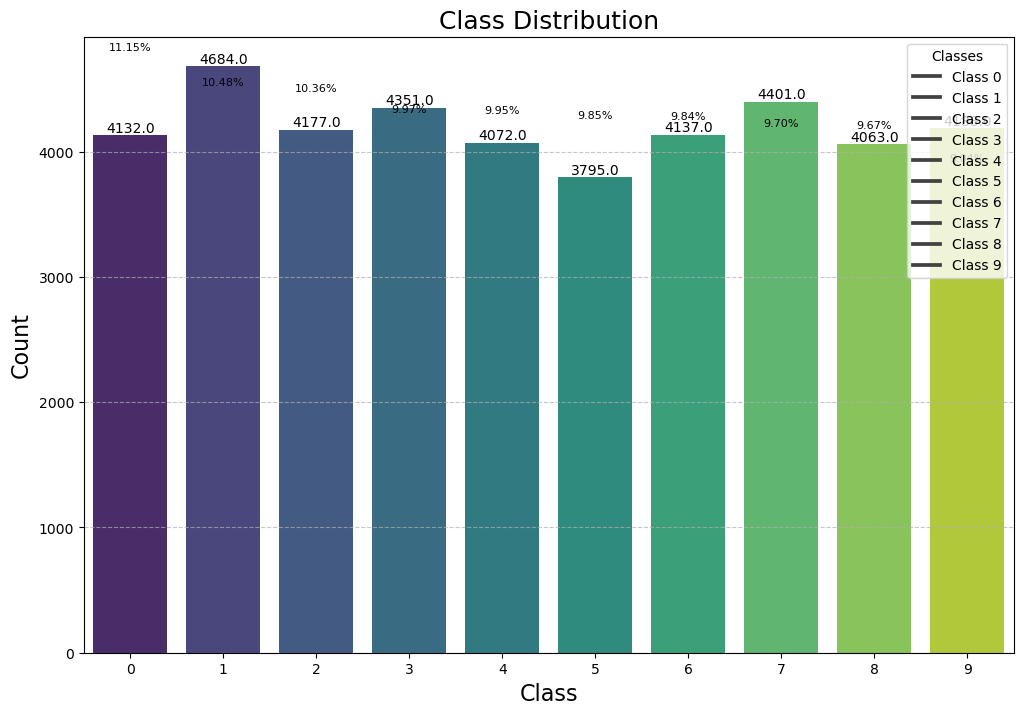

In [19]:
# Read the CSV file
train_df = pd.read_csv(train_csv)

# Set a color palette
sns.set_palette("viridis")

# Plotting
plt.figure(figsize=(12, 8))

# Bar chart with labels and color gradient
ax = sns.barplot(x=train_df['label'].value_counts().index, y=train_df['label'].value_counts().values, palette="viridis")

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add percentage annotations
total = len(train_df)
for i, count in enumerate(train_df['label'].value_counts()):
    percentage = (count / total) * 100
    ax.annotate(f'{percentage:.2f}%', (i, count), ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 10), textcoords='offset points')

# Customize plot
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Class Distribution', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(title='Classes', labels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'], loc='upper right')

# Show the plot
plt.show()

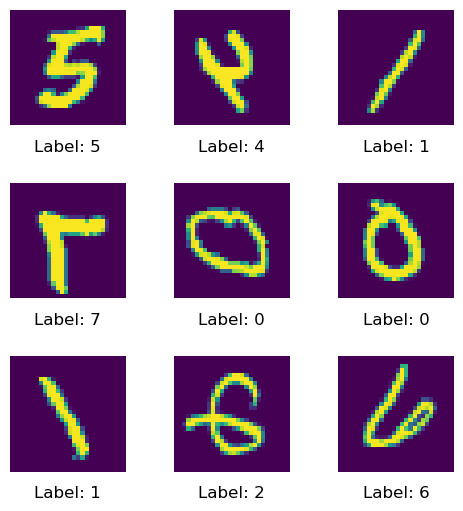

In [20]:
_,ax = plt.subplots(3,3,figsize=(6,6))
torch.manual_seed(81)
visualize_loader = DataLoader(train_dataset, batch_size=1,shuffle=True)

for i, (data,label) in enumerate(visualize_loader):
    
    
    ax[i//3][i%3].imshow(data.cpu().squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Label: {label.item()}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()

In [21]:
# Model initialization and optimizer setup
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

# Number of epochs
epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average training loss for the epoch
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            epoch_val_loss += val_loss.item()
        
        # Average validation loss for the epoch
        val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(val_loss)
    
    # Print epoch information
    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch: 1, Training Loss: 0.6261, Validation Loss: 0.0594
Epoch: 2, Training Loss: 0.2549, Validation Loss: 0.0143
Epoch: 3, Training Loss: 0.1898, Validation Loss: 0.0030
Epoch: 4, Training Loss: 0.1538, Validation Loss: 0.0018
Epoch: 5, Training Loss: 0.1410, Validation Loss: 0.0012
Epoch: 6, Training Loss: 0.1265, Validation Loss: 0.0018
Epoch: 7, Training Loss: 0.1159, Validation Loss: 0.0004
Epoch: 8, Training Loss: 0.1076, Validation Loss: 0.0029
Epoch: 9, Training Loss: 0.0995, Validation Loss: 0.0042
Epoch: 10, Training Loss: 0.0960, Validation Loss: 0.0008


In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


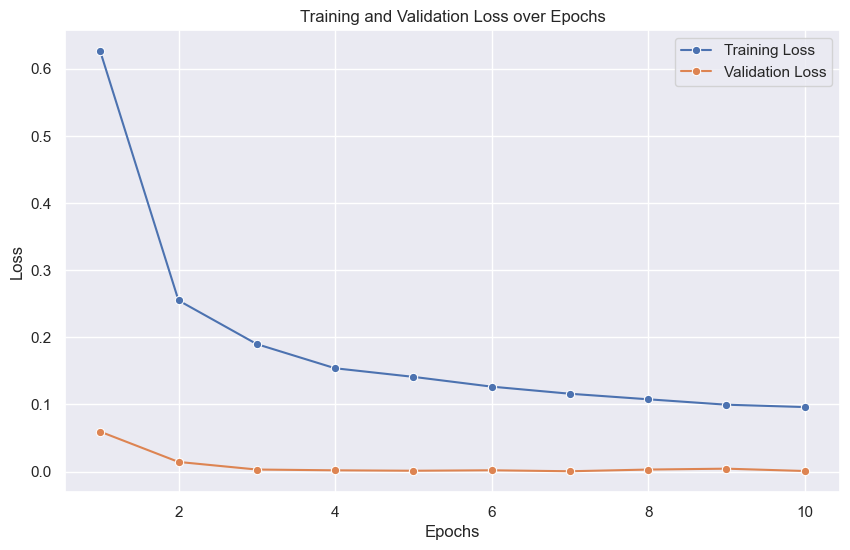

In [23]:
sns.set()
# Plotting the training and validation losses using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, epochs + 1), y=train_losses, label='Training Loss', marker='o')
sns.lineplot(x=range(1, epochs + 1), y=val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

Visualizing Predictions¶

AssertionError: Torch not compiled with CUDA enabled

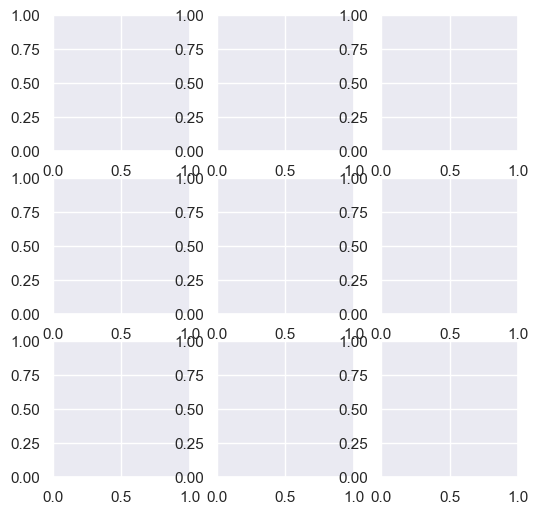

In [24]:
model.eval()
_,ax = plt.subplots(3,3,figsize=(6,6))
for i, data in enumerate(test_loader):
    
 
    data = data.cuda()

    output = model(data)
    

    pred = output.cpu().data.max(1, keepdim=True)[1]
    
    ax[i//3][i%3].imshow(data.cpu().squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Prediction: {pred.item()}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()

Submission

model.eval()
test_pred = torch.LongTensor()

for i, data in enumerate(test_loader):
    
    if torch.cuda.is_available():
        data = data.cuda()

    output = model(data)

    pred = output.cpu().data.max(1, keepdim=True)[1]
    test_pred = torch.cat((test_pred, pred), dim=0)
    
print(test_pred.shape)
submission_df = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission_df['Label'] = test_pred.numpy().squeeze()
submission_df.to_csv('submission.csv', index=False)


In [28]:
conda install pytorch torchvision torchaudio -c pytorch

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
Examining conflict for anaconda-project nbclassic pandas holoviews nltk bokeh ip- - - | - \ / / / / / - / ^C
                                                                               failed

Note: you may need to restart the kernel to use updated packages.
